# Advanced Lane Finding Project
## The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.<br />


In [1]:
#First the imports
import numpy as np
import cv2
import glob #it didn't work with me for some reason in the workspace but let's keep it just in case
import matplotlib.pyplot as plt
import matplotlib.image as mpimg #i will use the plotting method of the previous project

%matplotlib inline
#%matplotlib qt


## Now I'll compute the camera calibration using chessboard images

In [2]:

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx=9 #number of corners horizontally 
ny=6 #number of corners vertically
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.

objpoints = [] # 3d points in real world space, but the z coordinate has to always be zero, because the pictures were taken on a flat surface
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images

images=[]
for i in range(1,21):
    s='/home/workspace/CarND-Advanced-Lane-Lines/camera_cal/calibration'+str(i)+'.jpg'
    #print(s)
    img=mpimg.imread(s)
    images.append(img)
    
    #plt.imshow(img)
#print(len(images))

# Step through the list and search for chessboard corners

for img in images:
    #First transform to grayScale because this is what the cv2 calibration functions deal with
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp) 
        imgpoints.append(corners)
        #print(corners)

        # Draw and display the corners -Not an important step, just for testing and visualization
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #plt.imshow(img)
        
#NOW i have the corners of all the distorted images, it's time to calculate the calibration matrices

gray=cv2.cvtColor(images[1],cv2.COLOR_BGR2GRAY)
ret,mtx,dist,rvecs,tvecs=cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)

#Now that i have the matrices i want to test the undistortion correction, so i'll try it on one of the test images
# The output of my trials will be saved in this path ''
"""
testImageInput=mpimg.imread('/home/workspace/CarND-Advanced-Lane-Lines/camera_cal/calibration10.jpg')
testImageOutput= cv2.undistort(testImageInput,mtx,dist,None,mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testImageInput)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(testImageOutput)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

mpimg.imsave('/home/workspace/CarND-Advanced-Lane-Lines/test_images/undistort-output.jpg',testImageOutput )
"""
#Now that the testing worked fine, it means we have a good distortion correction matrices
#Each time i want to undistort a Frame, i call the cv2.undistort(frameImage,mtx,dist,None,mtx) and it returns
#the undistorted frame
#NOW let's head to the next step,Color Space transformation


"\ntestImageInput=mpimg.imread('/home/workspace/CarND-Advanced-Lane-Lines/camera_cal/calibration10.jpg')\ntestImageOutput= cv2.undistort(testImageInput,mtx,dist,None,mtx)\n\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(testImageInput)\nax1.set_title('Original Image', fontsize=50)\nax2.imshow(testImageOutput)\nax2.set_title('Undistorted Image', fontsize=50)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n\nmpimg.imsave('/home/workspace/CarND-Advanced-Lane-Lines/test_images/undistort-output.jpg',testImageOutput )\n"

## Now transform images into a suitable Color Space

In [3]:
#I'm going to transform the images into HLS: Hue, Light, Saturation Color Space because i'm expecting the images
#to be in difficult light conditions, so if we exclude the Light from HLS, we should find it easy to know the
# color of objects in the image
#Note to self: i made this step before the perspective transform because i just thought to transform a part of the
#image that's already undistorted and in binary form, is a nicer thing to do.. idk..


#Basically i'm going to get the gray scale,and the S channel from the HSL space and combine them to form a binray image

#First upload all the images 
testImages=[]
testImages.append(mpimg.imread('/home/workspace/CarND-Advanced-Lane-Lines/test_images/straight_lines1.jpg'))
testImages.append(mpimg.imread('/home/workspace/CarND-Advanced-Lane-Lines/test_images/straight_lines2.jpg'))

for i in range(1,7):
    s='/home/workspace/CarND-Advanced-Lane-Lines/test_images/test'+str(i)+'.jpg'
    #print(s)
    img=mpimg.imread(s)
    testImages.append(img)
    
#print(len(testImages))

def get_abs_mag_dir_binary(image, abs_thresh=(0, 255),mag_thresh=(0, 255),dir_thresh=(0, np.pi/2),sobel_kernel=3):
    
    ###First The magnitude part
    
    #First grayScale
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    #Get the "derivative" in the x direction
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F, 0,1,ksize=sobel_kernel)
    
    #idk if getting the mag is better or if getting sobelx only is better, but will try out everything, so let's see 
    mag= np.sqrt((sobelx**2)+(sobely**2))
    magScaled= np.uint8(mag*255/np.max(mag))
    
    magBinaryOutput= np.zeros_like(magScaled)
    magBinaryOutput[(magScaled>=mag_thresh[0]) & (magScaled<=mag_thresh[1])]=1
    
    
    ##Second For the Direction part
    
    sobelx_abs=np.absolute(sobelx)
    sobely_abs=np.absolute(sobely)  
    
    
    direction=np.arctan2(sobely_abs,sobelx_abs) 
    
    dirBinaryOutput=np.zeros_like(direction)
    dirBinaryOutput[(direction>=dir_thresh[0]) & (direction<=dir_thresh[1])]=1 
    
    #Finally for the ABSOLUTE PART
    abs_scaled =np.uint8(255*sobelx_abs/np.max(sobelx_abs)) 
    absBinary= np.zeros_like(abs_scaled)
    absBinary[(abs_scaled>= abs_thresh[0]) & (abs_scaled <= abs_thresh[1])] =1
    
    #NOW COMBINE
    combined = np.zeros_like(dirBinaryOutput)
    #combined[(absBinary == 1) |((magBinaryOutput == 1) & (dirBinaryOutput == 1))] = 1
    #combined[(absBinary == 1) &(  (dirBinaryOutput == 1))] = 1
    combined[(absBinary == 1) |((magBinaryOutput == 1) )] = 1


    
    
    return absBinary


def get_s_binary(img, s_thresh=(0, 255)):
    
    hls=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    #I remember from the quizes and my trials that the S channel was the best in different lighting conditions so..
    s=hls[:,:,2]
    

    binary_output=np.zeros_like(s)
    binary_output[(s>s_thresh[0]) & (s<=s_thresh[1])]=1 
    
    
    return binary_output

#TESTING
"""
outt=get_abs_mag_dir_binary(testImages[6],abs_thresh=(20,100),mag_thresh=(200, 255),dir_thresh=(0.7, 1.3))
#outt=get_s_binary(testImages[6],s_thresh=(165,255))
#plt.imshow(outt)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testImages[6])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(outt, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
"""



#Now let's define a function that transforms each frame/image into my combined binary fram/image
def getCombinedBinary(image,Abs_Thresh=(15,100),Mag_Thresh=(100, 255),Dir_Thresh=(0.7, 1.3),S_Thresh=(170,255),Sobel_Kernel=3):
    """
    #s_thresh=(170, 255), sx_thresh=(20, 100)
    #First grayScale
    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    #Get the "derivative" in the x direction
    sobelx=cv2.Sobel(gray,cv2.CV_64F, 1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F, 0,1,ksize=sobel_kernel)
    
    #idk if getting the mag is better or if getting sobelx only is better, but will try out everything, so let's see 
    mag= np.sqrt((sobelx**2)+(sobely**2))
    magScaled= np.uint8(mag*255/np.max(mag))
    
    magBinaryOutput= np.zeros_like(mag_scaled)
    magBinaryOutput[(mag_scaled>=mag_thresh[0]) & (mag_scaled<=mag_thresh[1])]=1
    """
    outt1=get_abs_mag_dir_binary(image,abs_thresh=Abs_Thresh,mag_thresh=Mag_Thresh,dir_thresh=Dir_Thresh,sobel_kernel=Sobel_Kernel)
    outt2=get_s_binary(image,s_thresh=S_Thresh)
    
    #combined = np.dstack(( np.zeros_like(outt1), outt1, outt2)) * 255
    
    #E7NA WE2FNA YA YOMNA W 3ANDK MOSHKELA FE EL OUTPUT BYTLA3 FE BO23A BEL3ARD KEDA+ MSH 3ARFEN NE3ML DSTACK W HYA SHAKLAHA MOHEMA BTW 
    combined = np.zeros_like(outt2)
    combined[((outt1 == 1) | (outt2 == 1))] = 1

    return combined
"""
#TESTING
#FIRST FIX THE IMAGE DISTORTION
image_=cv2.undistort(testImages[5],mtx,dist,None,mtx)
    
outt=getCombinedBinary(image_)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testImages[5])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(outt, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
   
"""
#Now we test this pipeline on the 8 images in the examples directory


"\n#TESTING\n#FIRST FIX THE IMAGE DISTORTION\nimage_=cv2.undistort(testImages[5],mtx,dist,None,mtx)\n    \noutt=getCombinedBinary(image_)\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(testImages[5])\nax1.set_title('Original Image', fontsize=50)\nax2.imshow(outt, cmap='gray')\nax2.set_title('Thresholded Magnitude', fontsize=50)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n   \n"

## Now time for Perspective Transform

In [4]:
#Let's pick an area that most probably represents a rectangle in the real world 
#Let's define a function for transforming each image
def persp_trans(img):
    img_size=(img.shape[1],img.shape[0])
     
    src=np.float32(
        [[195,img.shape[0]],   #Low_Left
         [1140,img.shape[0]],   #Low_Right
         [550,470],            #Up_Left
         [720,470]])           #Up_Right
    
    offset=300
    
    dst=np.float32(
        [[offset,img.shape[0]],
         [img.shape[1]-offset,img.shape[0]],
         [offset,offset],
         [img.shape[1]-offset,offset]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv
"""
#TEST
pres_trans_output=persp_trans(outt)
plt.imshow(pres_trans_output)
""" 

'\n#TEST\npres_trans_output=persp_trans(outt)\nplt.imshow(pres_trans_output)\n'

### Now we (suppose that we) have a reasonable lane detection, curvature calculation, pos estimation let's warp the image back and do the visual supporting to each frame

In [5]:

def unwarp(undist,warped,left_fitx,right_fitx,ploty,Minv,lefty,leftx,righty,rightx):
    """
    print('warped input',warped.shape[0])
    print('warped input',warped.shape[1])
    print('warped input',warped.shape[2])

    print('undist input',undist.shape[0])
    print('undist input',undist.shape[1])
    print('undist input',undist.shape[2])
    """
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp=warp_zero
    """
    print ('color_warp' ,color_warp.shape[0])
    print ('color_warp' ,color_warp.shape[1])
    print ('color_warp' ,color_warp.shape[2])
    """
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    color_warp[lefty, leftx] = [255, 0, 0]   #RED LEFT CURVE
    color_warp[righty, rightx] = [0, 0, 255] #BLUE RIGHT CURVE
    print(lefty)


    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    
    return result
    #return warped


## Now let's apply our algorithms to detect the lane lines
### First the histogram peaks, the window search

In [6]:
def find_lane_pixels(img):
    pres_trans_output=img/255
    bottom_half=pres_trans_output[img.shape[0]//2:,:]
    
    histogram=np.sum(bottom_half,axis=0)
    
    out_img = np.dstack((img, img, img))
    #out_img=img
    
    #Now pick a point to in the middle of the left half and the right half as a starting point
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    for_veh_pos=[]
    for_veh_pos.append(midpoint)
    for_veh_pos.append(leftx_base)
    for_veh_pos.append(rightx_base)
    
    #HYPERPARAMETERS
    nwindows=9
    margin=100
    minpix=50
    window_height = np.int(img.shape[0]//nwindows)
    
    #Determine the nonzero pixels in the whole wraped binary image  
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Update the current x coordinate of the center of the window  
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    #Now iterate for each window
    for window in range(nwindows):
        #First identify the boundaries of each window
        
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        
        win_xleft_low = leftx_current-margin
        win_xleft_high = leftx_current+margin
        win_xright_low = rightx_current-margin
        win_xright_high = rightx_current+margin
        """
        print(win_y_low)
        print(win_y_high)
        print(win_xleft_low)
        print(win_xleft_high)
        print(win_xright_high)
        print(win_xright_low)
        """
        """
        #Now draw rectangles, but this is just for visualization it's not important for the pipeline
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        """
        #Extract the nonzero points which are inside each window (simple geometry)#
        good_left_inds = ((nonzeroy>=win_y_low)&(nonzeroy<win_y_high)&(nonzerox>=win_xleft_low)&(nonzerox<win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy>=win_y_low)&(nonzeroy<win_y_high)&(nonzerox>=win_xright_low)&(nonzerox<win_xright_high)).nonzero()[0]
        #Now this is like a list for each window, append it to an integration array
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #Recenter window if the number of nonzero pixels found inside of it is larger than minpix(let's tune this part as well)#
        
        if len(good_left_inds)> minpix :
            leftx_current=np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)>minpix :
            rightx_current=np.int(np.mean(nonzerox[good_right_inds]))
        
    #Now this is the end of our iteration over each window
    #Let's combine all the lane pixles found into one integration list
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully,, i kept this because
        #If no pixles were found (just mere error handling)
        pass
    
    #Now that we have a right and a left list that represent the lane's pixles(in a 0 or 1 form allover the nonzero arrays as i understood)#
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img,for_veh_pos


        
    
    
    
    



    
#TEST
#plt.plot(histo(pres_trans_output)) #this is when it only returned a histogram plot 
#leftx, lefty, rightx, righty, out_img=find_lane_pixels(pres_trans_output)
#outtt=np.dstack((np.zeros_like(out_img),out_img,pres_trans_output))
#out_img[lefty, leftx] = [255, 0, 0]
#out_img[righty, rightx] = [0, 0, 255]

#plt.imshow(out_img)


##  Now let's apply our fitting polynomial algorithm and calculate the curvature in the pixel space

In [21]:
def fit_poly(img,undist,Minv):
    #First of course call the window algorithm function to determined the pixles
    leftx, lefty, rightx, righty, out_img,for_veh_pos=find_lane_pixels(img)
    
    #As we can see, it returns lists of points which are supposed to form a curve, so let's fit a curve to them
    #Let's assume the equation is of degree 2 
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    
    #now forget about the pixels we got before -for a while-, now we have a curve!
    #Let's generate y values for this curve
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    
    #Let's get the correspoinding x values of each curve 
    #Simple algebra this is done by substituting the ploty (y values) in the curve's equation
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        #If that happen's let's assume the coefficients ourselves to be ones
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
        
    #This part is for visualization it's not important for the pipeline
    out_img[lefty, leftx] = [255, 0, 0]   #RED LEFT CURVE
    out_img[righty, rightx] = [0, 0, 255] #BLUE RIGHT CURVE

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    #
    #
    #
    #
    
    #NOW for the curve calculation part
    """
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    
    y_eval = np.max(ploty)
    
    #left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
   
    
    left_curverad = ((1+(2*left_fit[0]*y_eval*ym_per_pix+left_fit[1])**2))**1.5/np.absolute(2*left_fit[0])
    right_curverad = ((1+(2*right_fit[0]*y_eval*ym_per_pix+right_fit[1])**2))**1.5/np.absolute(2*right_fit[0])
    """
    
    # Define conversions in x and y from pixels space to meters
    my = 30/700 # meters per pixel in y dimension
    mx = 3.7/600 # meters per pixel in x dimension
    
    #ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    
    #y_eval = np.max(ploty)*my
    #print(y_eval)
    y_eval=700
    
    #Let's use the student's approach
    
    #x= mx / (my ** 2) *a*(y**2)+(mx/my)*b*y+c
    
    left_fit[0]= mx/(my**2)*left_fit[0]
    right_fit[0]=mx/(my**2)*right_fit[0]
    
    left_fit[1]=(mx/my)*left_fit[1]
    right_fit[1]=(mx/my)*right_fit[1]
    
    #Now we have the curves in the real world dimensions, we can substitute in the curvature equation with ease
    left_curverad = (1+(2*left_fit[0]*y_eval+left_fit[1])**2)**(3/2)/ (np.absolute(2*left_fit[0]))
    right_curverad =  (1+(2*right_fit[0]*y_eval+right_fit[1])**2)**(3/2)/ (np.absolute(2*right_fit[0])) 
    
    
    #print(left_curverad,'m', right_curverad,'m')
    radius=(left_curverad+right_curverad)/2
    #text1='Radius of Curvature is =' +str(radius)+'m'
    #z = “In the basket are %s and %s” % (x,y)
    text1="Radius of Curvature is = %.2f m" %radius 
    
    #NOW let's try to calculate the vehicles position with respect to the lane's center
    lanes_mid=(for_veh_pos[1]+for_veh_pos[2])//2
    frame_mid=for_veh_pos[0]
    veh_pos_pixel= lanes_mid-frame_mid
    veh_pos_m = veh_pos_pixel*mx
    veh_pos_m=abs(veh_pos_m)
    if veh_pos_pixel>0 : #positive this means the vehicle is shifted left (because the lanes_mid is larger)
        #print('vehicle approximately shifted left with',veh_pos_m,'m')
        #text2='vehicle approximately shifted left with',str(veh_pos_m),'m'
        text2= "Vehicle is %.2f m left of the center " %veh_pos_m
    
    elif veh_pos_pixel<0: #negative this means the vehicle is shifted right
        #print('vehicle approximately shifted right',veh_pos_m,'m')
        #text2='vehicle approximately shifted right',str(veh_pos_m),'m'
        text2="Vehicle is %.2f m right of the center" %veh_pos_m
    elif veh_pos_pixel == 0: #Centered correctly
        #print('vehicle approximately centered')
        text2='Vehicle approximately centered'
        
        
    
    
    
    #NOW TO UNWARP THE FRAAAAAAME YA RAB
    unwarpped=unwarp(undist,out_img, left_fitx, right_fitx, ploty,Minv,lefty,leftx,righty,rightx)
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (11,100)
    fontScale              = 2
    fontColor              = (255,255,255)
    lineType               = 3

    cv2.putText(unwarpped,text1, 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    
    bottomLeftCornerOfText = (11,150)
    
    cv2.putText(unwarpped,text2, 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)
    

        
    

    return unwarpped

"""
##Testing
out_img = fit_poly(pres_trans_output)

plt.imshow(out_img)
   """ 
    
    

'\n##Testing\nout_img = fit_poly(pres_trans_output)\n\nplt.imshow(out_img)\n   '

## Pipeline to test images  

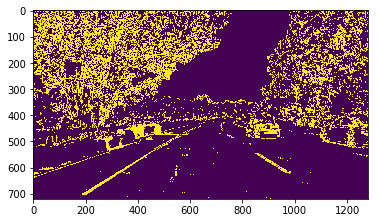

In [8]:
#Remember the test images were uploaded in the Color Space cell
#First the distortion and the color space 

testtest=testImages[6]

#FIRST FIX THE IMAGE DISTORTION
image_=cv2.undistort(testtest,mtx,dist,None,mtx)

binImg=getCombinedBinary(image_)

plt.imshow(binImg)

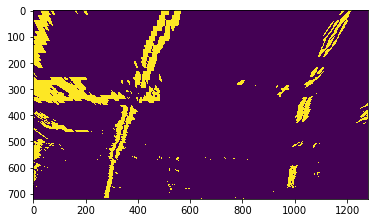

In [9]:
pres,M_,Minv_=persp_trans(binImg)
plt.imshow(pres)

4255.16596371 m 5524.55848325 m
vehicle approximately shifted left with 0.1665 m
[640 640 640 ...,  79  79  79]


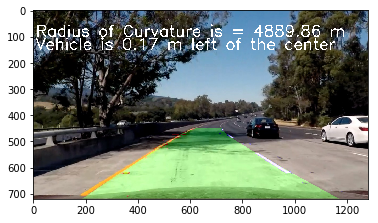

In [20]:
outimg = fit_poly(pres,image_,Minv_)



plt.imshow(outimg)


## Let's add the class that shall help us when detecting lanes becomes a rough job

In [ ]:
#Now my scenario is 
# Receive uhmm 5 frames and process them through the regular testImages pipeline, then record the output lines-data
#in an array of Line objects (size 5),, uh right, before accepting each object data, it should be validated
#which means it should pass the sanity checks: - similar curvature values - seperated by a reasonable horizontal
#distance - roughly paralell(i think it's the same as similar curvature lol)
#so when this 'first 5 frames' stage finishes ; 
# we head to the stage of relying on them

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

## The lanes' coloring isn't the best i can, but let's for now head to
## Try it on video! 


In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [12]:
def process_frame(frame):
    #Pipeline
    undistorted_frame=cv2.undistort(frame,mtx,dist,None,mtx)
    colorTransformed_frame=getCombinedBinary(undistorted_frame)
    presTrans_frame,M_,Minv_=persp_trans(colorTransformed_frame)
    final_frame = fit_poly(presTrans_frame,undistorted_frame,Minv_)
    

    

    
    
    
    
    
    return final_frame
    

In [18]:
output_video='/home/workspace/CarND-Advanced-Lane-Lines/output_video.mp4'
clip1 = VideoFileClip("/home/workspace/CarND-Advanced-Lane-Lines/project_video.mp4").subclip(0,10)
each_clip = clip1.fl_image(process_frame)
%time each_clip.write_videofile(output_video, audio=False)



3094.38486001 m 1979.37131508 m
vehicle approximately shifted left with 0.339166666667 m
[640 640 640 ...,  79  79  79]
[MoviePy] >>>> Building video /home/workspace/CarND-Advanced-Lane-Lines/output_video.mp4
[MoviePy] Writing video /home/workspace/CarND-Advanced-Lane-Lines/output_video.mp4


  0%|          | 1/251 [00:00<01:30,  2.77it/s]

3094.38486001 m 1979.37131508 m
vehicle approximately shifted left with 0.339166666667 m
[640 640 640 ...,  79  79  79]


  1%|          | 2/251 [00:00<01:27,  2.84it/s]

3231.12706901 m 2219.0877364 m
vehicle approximately shifted left with 0.363833333333 m
[640 640 640 ...,  79  79  79]


  1%|          | 3/251 [00:01<01:24,  2.94it/s]

3323.16394187 m 1930.08396917 m
vehicle approximately shifted left with 0.3515 m
[640 640 640 ...,  79  79  79]


  2%|▏         | 4/251 [00:01<01:20,  3.07it/s]

3775.91019476 m 1959.50021237 m
vehicle approximately shifted left with 0.296 m
[640 640 640 ...,  79  79  79]


  2%|▏         | 5/251 [00:01<01:18,  3.15it/s]

3036.50291539 m 2708.73839086 m
vehicle approximately shifted left with 0.265166666667 m
[640 640 640 ...,  79  79  79]


  2%|▏         | 6/251 [00:01<01:17,  3.18it/s]

2632.79857061 m 2966.57290333 m
vehicle approximately shifted left with 0.308333333333 m
[640 640 640 ...,  79  79  79]


  3%|▎         | 7/251 [00:02<01:15,  3.23it/s]

2571.22541403 m 3101.90392739 m
vehicle approximately shifted left with 0.252833333333 m
[640 640 640 ...,  79  79  79]


  3%|▎         | 8/251 [00:02<01:13,  3.29it/s]

2790.16192145 m 2594.96876592 m
vehicle approximately shifted left with 0.302166666667 m
[640 640 640 ...,  79  79  79]


  4%|▎         | 9/251 [00:02<01:12,  3.34it/s]

2435.56585617 m 2359.42093351 m
vehicle approximately shifted left with 0.296 m
[640 640 640 ...,  79  79  79]


  4%|▍         | 10/251 [00:03<01:11,  3.38it/s]

2575.89314466 m 1954.64102456 m
vehicle approximately shifted left with 0.271333333333 m
[640 640 640 ...,  79  79  79]


  4%|▍         | 11/251 [00:03<01:10,  3.39it/s]

2448.62202381 m 1706.1878124 m
vehicle approximately shifted left with 0.252833333333 m
[640 640 640 ...,  79  79  79]


  5%|▍         | 12/251 [00:03<01:10,  3.39it/s]

2000.76768128 m 1835.46164812 m
vehicle approximately shifted left with 0.320666666667 m
[640 640 640 ...,  79  79  79]


  5%|▌         | 13/251 [00:03<01:10,  3.40it/s]

2045.67830112 m 1989.23753557 m
vehicle approximately shifted left with 0.296 m
[640 640 640 ...,  79  79  79]


  6%|▌         | 14/251 [00:04<01:10,  3.38it/s]

2227.15424438 m 2215.83959654 m
vehicle approximately shifted left with 0.308333333333 m
[640 640 640 ...,  79  79  79]


  6%|▌         | 15/251 [00:04<01:11,  3.31it/s]

2508.34265506 m 1997.0128757 m
vehicle approximately shifted left with 0.308333333333 m
[640 640 640 ...,  79  79  79]


  6%|▋         | 16/251 [00:04<01:10,  3.34it/s]

2636.45271683 m 2598.08361946 m
vehicle approximately shifted left with 0.3145 m
[640 640 640 ...,  79  79  79]


  7%|▋         | 17/251 [00:05<01:10,  3.34it/s]

2565.98759806 m 3286.01203612 m
vehicle approximately shifted left with 0.308333333333 m
[640 640 640 ...,  79  79  79]


  7%|▋         | 18/251 [00:05<01:10,  3.33it/s]

2513.16976778 m 3219.53887871 m
vehicle approximately shifted left with 0.1665 m
[640 640 640 ...,  79  79  79]


  8%|▊         | 19/251 [00:05<01:09,  3.33it/s]

2343.31475399 m 3403.9802402 m
vehicle approximately shifted left with 0.185 m
[640 640 640 ...,  79  79  79]


  8%|▊         | 20/251 [00:06<01:09,  3.33it/s]

2343.84780506 m 3421.32993769 m
vehicle approximately shifted left with 0.178833333333 m
[640 640 640 ...,  79  79  79]


  8%|▊         | 21/251 [00:06<01:10,  3.27it/s]

2245.13564109 m 3488.25100449 m
vehicle approximately shifted left with 0.191166666667 m
[640 640 640 ...,  79  79  79]


  9%|▉         | 22/251 [00:06<01:10,  3.25it/s]

2154.78767258 m 3298.65615868 m
vehicle approximately shifted left with 0.2035 m
[640 640 640 ...,  79  79  79]


  9%|▉         | 23/251 [00:06<01:09,  3.30it/s]

2011.69139684 m 3269.78886056 m
vehicle approximately shifted left with 0.228166666667 m
[640 640 640 ...,  79  79  79]


 10%|▉         | 24/251 [00:07<01:09,  3.27it/s]

2218.47799495 m 2443.78087443 m
vehicle approximately shifted left with 0.234333333333 m
[640 640 640 ...,  79  79  79]


 10%|▉         | 25/251 [00:07<01:08,  3.29it/s]

2422.94609078 m 2206.18558033 m
vehicle approximately shifted left with 0.215833333333 m
[640 640 640 ...,  79  79  79]


 10%|█         | 26/251 [00:07<01:07,  3.33it/s]

2348.20547073 m 1823.0703171 m
vehicle approximately shifted left with 0.228166666667 m
[640 640 640 ...,  79  79  79]


 11%|█         | 27/251 [00:08<01:07,  3.33it/s]

2643.47198631 m 2154.17016871 m
vehicle approximately shifted left with 0.234333333333 m
[640 640 640 ...,  79  79  79]


 11%|█         | 28/251 [00:08<01:06,  3.34it/s]

2443.71994597 m 1984.92347819 m
vehicle approximately shifted left with 0.234333333333 m
[640 640 640 ...,  79  79  79]


 12%|█▏        | 29/251 [00:08<01:06,  3.33it/s]

2870.34720054 m 2584.7595563 m
vehicle approximately shifted left with 0.228166666667 m
[640 640 640 ...,  79  79  79]


 12%|█▏        | 30/251 [00:09<01:06,  3.33it/s]

2992.417029 m 2115.19999445 m
vehicle approximately shifted left with 0.228166666667 m
[640 640 640 ...,  79  79  79]


 12%|█▏        | 31/251 [00:09<01:06,  3.29it/s]

3088.83289141 m 3355.42172477 m
vehicle approximately shifted left with 0.117166666667 m
[640 640 640 ...,  79  79  79]


 13%|█▎        | 32/251 [00:09<01:05,  3.33it/s]

3567.72889723 m 4119.18675367 m
vehicle approximately shifted left with 0.1295 m
[640 640 640 ...,  79  79  79]


 13%|█▎        | 33/251 [00:09<01:05,  3.34it/s]

3650.15647036 m 4598.42476774 m
vehicle approximately shifted left with 0.185 m
[640 640 640 ...,  79  79  79]


 14%|█▎        | 34/251 [00:10<01:04,  3.35it/s]

3918.86331788 m 3756.01975465 m
vehicle approximately shifted left with 0.160333333333 m
[640 640 640 ...,  79  79  79]


 14%|█▍        | 35/251 [00:10<01:04,  3.36it/s]

4174.07701282 m 3076.6926748 m
vehicle approximately shifted left with 0.2035 m
[640 640 640 ...,  79  79  79]


 14%|█▍        | 36/251 [00:10<01:03,  3.38it/s]

4564.26523069 m 3029.06641029 m
vehicle approximately shifted left with 0.215833333333 m
[640 640 640 ...,  79  79  79]


 15%|█▍        | 37/251 [00:11<01:03,  3.37it/s]

4693.22716817 m 3599.53541336 m
vehicle approximately shifted left with 0.2405 m
[640 640 640 ...,  79  79  79]


 15%|█▌        | 38/251 [00:11<01:02,  3.38it/s]

4999.0408282 m 3741.93230222 m
vehicle approximately shifted left with 0.222 m
[640 640 640 ...,  79  79  79]


 16%|█▌        | 39/251 [00:11<01:02,  3.40it/s]

4910.34313331 m 3572.4723372 m
vehicle approximately shifted left with 0.2405 m
[640 640 640 ...,  79  79  79]


 16%|█▌        | 40/251 [00:12<01:02,  3.39it/s]

4653.28792519 m 3552.09526146 m
vehicle approximately shifted left with 0.228166666667 m
[640 640 640 ...,  79  79  79]


 16%|█▋        | 41/251 [00:12<01:02,  3.39it/s]

4491.90475175 m 4212.06385453 m
vehicle approximately shifted left with 0.234333333333 m
[640 640 640 ...,  79  79  79]


 17%|█▋        | 42/251 [00:12<01:01,  3.40it/s]

4265.94499452 m 4263.37633071 m
vehicle approximately shifted left with 0.117166666667 m
[640 640 640 ...,  79  79  79]


 17%|█▋        | 43/251 [00:13<01:19,  2.62it/s]

3910.03407322 m 4305.27173829 m
vehicle approximately shifted left with 0.117166666667 m
[640 640 640 ...,  79  79  79]


 18%|█▊        | 44/251 [00:13<01:19,  2.62it/s]

3917.78643918 m 4093.05946037 m
vehicle approximately shifted left with 0.209666666667 m
[640 640 640 ...,  79  79  79]


 18%|█▊        | 45/251 [00:14<01:21,  2.53it/s]

3568.64193493 m 4165.78194418 m
vehicle approximately shifted left with 0.234333333333 m
[640 640 640 ...,  79  79  79]


 18%|█▊        | 46/251 [00:14<01:20,  2.54it/s]

3492.72988854 m 4026.69963822 m
vehicle approximately shifted left with 0.2405 m
[640 640 640 ...,  79  79  79]


 19%|█▊        | 47/251 [00:14<01:17,  2.64it/s]

3510.80045262 m 3669.48177276 m
vehicle approximately shifted left with 0.228166666667 m
[640 640 640 ...,  79  79  79]


 19%|█▉        | 48/251 [00:15<01:16,  2.65it/s]

3335.54033079 m 2786.06072484 m
vehicle approximately shifted left with 0.228166666667 m
[640 640 640 ...,  79  79  79]


 20%|█▉        | 49/251 [00:15<01:13,  2.74it/s]

2860.06898544 m 2781.11075179 m
vehicle approximately shifted left with 0.222 m
[640 640 640 ...,  79  79  79]


 20%|█▉        | 50/251 [00:15<01:14,  2.70it/s]

2835.44651718 m 2966.93381142 m
vehicle approximately shifted left with 0.215833333333 m
[640 640 640 ...,  79  79  79]


 20%|██        | 51/251 [00:16<01:12,  2.77it/s]

2624.51218088 m 2871.97945963 m
vehicle approximately shifted left with 0.228166666667 m
[640 640 640 ...,  79  79  79]


 21%|██        | 52/251 [00:16<01:13,  2.71it/s]

2833.09436834 m 2580.82876184 m
vehicle approximately shifted left with 0.209666666667 m
[640 640 640 ...,  79  79  79]


 21%|██        | 53/251 [00:16<01:10,  2.79it/s]

2927.58900419 m 2556.17556649 m
vehicle approximately shifted left with 0.246666666667 m
[640 640 640 ...,  79  79  79]


 22%|██▏       | 54/251 [00:17<01:11,  2.75it/s]

2923.16904651 m 3177.676235 m
vehicle approximately shifted left with 0.234333333333 m
[640 640 640 ...,  79  79  79]


 22%|██▏       | 55/251 [00:17<01:10,  2.79it/s]

2596.41492446 m 3505.01406565 m
vehicle approximately shifted left with 0.135666666667 m
[640 640 640 ...,  79  79  79]


 22%|██▏       | 56/251 [00:18<01:11,  2.73it/s]

2528.25687211 m 3585.95766461 m
vehicle approximately shifted left with 0.154166666667 m
[640 640 640 ...,  79  79  79]


 23%|██▎       | 57/251 [00:18<01:12,  2.66it/s]

2503.24279623 m 3320.99400469 m
vehicle approximately shifted left with 0.141833333333 m
[640 640 640 ...,  79  79  79]


 23%|██▎       | 58/251 [00:18<01:10,  2.74it/s]

2385.27075961 m 3243.0110395 m
vehicle approximately shifted left with 0.141833333333 m
[640 640 640 ...,  79  79  79]


 24%|██▎       | 59/251 [00:19<01:11,  2.68it/s]

2741.77689064 m 2571.33235339 m
vehicle approximately shifted left with 0.172666666667 m
[640 640 640 ...,  79  79  79]


 24%|██▍       | 60/251 [00:19<01:09,  2.75it/s]

2771.89762163 m 2643.91222656 m
vehicle approximately shifted left with 0.123333333333 m
[640 640 640 ...,  79  79  79]


 24%|██▍       | 61/251 [00:19<01:10,  2.69it/s]

2549.91180853 m 2934.54118809 m
vehicle approximately shifted left with 0.154166666667 m
[640 640 640 ...,  79  79  79]


 25%|██▍       | 62/251 [00:20<01:08,  2.77it/s]

2688.03033342 m 3346.88879989 m
vehicle approximately shifted left with 0.154166666667 m
[640 640 640 ...,  79  79  79]


 25%|██▌       | 63/251 [00:20<01:08,  2.73it/s]

2632.79891083 m 3315.98466232 m
vehicle approximately shifted left with 0.160333333333 m
[640 640 640 ...,  79  79  79]


 25%|██▌       | 64/251 [00:20<01:07,  2.79it/s]

2636.24187862 m 4006.07804565 m
vehicle approximately shifted left with 0.172666666667 m
[640 640 640 ...,  79  79  79]


 26%|██▌       | 65/251 [00:21<01:07,  2.76it/s]

2339.4551759 m 3693.72758537 m
vehicle approximately shifted left with 0.172666666667 m
[640 640 640 ...,  79  79  79]


 26%|██▋       | 66/251 [00:21<01:05,  2.83it/s]

2552.83593807 m 3347.49720325 m
vehicle approximately shifted left with 0.228166666667 m
[640 640 640 ...,  79  79  79]


 27%|██▋       | 67/251 [00:22<01:07,  2.74it/s]

2604.70534308 m 3217.78494231 m
vehicle approximately shifted left with 0.178833333333 m
[640 640 640 ...,  79  79  79]


 27%|██▋       | 68/251 [00:22<01:06,  2.77it/s]

2682.91303405 m 3113.85386041 m
vehicle approximately shifted right 0.0123333333333 m
[640 640 640 ...,  79  79  79]


 27%|██▋       | 69/251 [00:22<01:07,  2.70it/s]

2521.9295428 m 3032.91468756 m
vehicle approximately shifted left with 0.00616666666667 m
[640 640 640 ...,  79  79  79]


 28%|██▊       | 70/251 [00:23<01:05,  2.78it/s]

2553.09604397 m 3040.35561202 m
vehicle approximately shifted left with 0.0246666666667 m
[640 640 640 ...,  79  79  79]


 28%|██▊       | 71/251 [00:23<01:06,  2.71it/s]

2605.26818229 m 3771.29840801 m
vehicle approximately shifted left with 0.0246666666667 m
[640 640 640 ...,  79  79  79]


 29%|██▊       | 72/251 [00:23<01:05,  2.74it/s]

2533.12973421 m 3811.46908339 m
vehicle approximately shifted left with 0.0431666666667 m
[640 640 640 ...,  79  79  79]


 29%|██▉       | 73/251 [00:24<01:06,  2.66it/s]

2168.0630694 m 3542.99764603 m
vehicle approximately shifted left with 0.0431666666667 m
[640 640 640 ...,  79  79  79]


 29%|██▉       | 74/251 [00:24<01:04,  2.73it/s]

2362.5098958 m 2984.06319356 m
vehicle approximately shifted left with 0.0863333333333 m
[640 640 640 ...,  79  79  79]


 30%|██▉       | 75/251 [00:24<01:05,  2.69it/s]

2133.67817615 m 3012.91384818 m
vehicle approximately shifted left with 0.104833333333 m
[640 640 640 ...,  79  79  79]


 30%|███       | 76/251 [00:25<01:03,  2.76it/s]

2205.40375306 m 3205.5738987 m
vehicle approximately shifted left with 0.074 m
[640 640 640 ...,  79  79  79]


 31%|███       | 77/251 [00:25<01:03,  2.72it/s]

2093.73176891 m 2844.78055053 m
vehicle approximately shifted left with 0.0986666666667 m
[640 640 640 ...,  79  79  79]


 31%|███       | 78/251 [00:26<01:01,  2.79it/s]

1973.10880617 m 2679.28773775 m
vehicle approximately shifted left with 0.0925 m
[640 640 640 ...,  79  79  79]


 31%|███▏      | 79/251 [00:26<01:02,  2.74it/s]

1958.03232572 m 2948.17713165 m
vehicle approximately shifted left with 0.074 m
[640 640 640 ...,  79  79  79]


 32%|███▏      | 80/251 [00:26<01:00,  2.81it/s]

2050.26633357 m 2598.06819797 m
vehicle approximately shifted left with 0.0925 m
[640 640 640 ...,  79  79  79]


 32%|███▏      | 81/251 [00:27<01:01,  2.74it/s]

2154.85793466 m 3501.1656183 m
vehicle approximately shifted right 0.00616666666667 m
[640 640 640 ...,  79  79  79]


 33%|███▎      | 82/251 [00:27<01:00,  2.81it/s]

2216.60030013 m 3623.99276847 m
vehicle approximately shifted left with 0.0801666666667 m
[640 640 640 ...,  79  79  79]


 33%|███▎      | 83/251 [00:27<01:01,  2.74it/s]

2295.47721354 m 3406.57123892 m
vehicle approximately shifted left with 0.074 m
[640 640 640 ...,  79  79  79]


 33%|███▎      | 84/251 [00:28<00:59,  2.82it/s]

2315.38186195 m 3554.82027659 m
vehicle approximately shifted left with 0.074 m
[640 640 640 ...,  79  79  79]


 34%|███▍      | 85/251 [00:28<01:00,  2.74it/s]

2351.35663909 m 3010.61337521 m
vehicle approximately shifted left with 0.0246666666667 m
[640 640 640 ...,  79  79  79]


 34%|███▍      | 86/251 [00:28<00:58,  2.81it/s]

2601.06434338 m 2443.8846198 m
vehicle approximately shifted left with 0.0801666666667 m
[640 640 640 ...,  79  79  79]


 35%|███▍      | 87/251 [00:29<00:59,  2.75it/s]

3076.65609759 m 2502.00786389 m
vehicle approximately shifted left with 0.0678333333333 m
[640 640 640 ...,  79  79  79]


 35%|███▌      | 88/251 [00:29<00:58,  2.81it/s]

3260.74637915 m 2935.62345191 m
vehicle approximately shifted left with 0.0801666666667 m
[640 640 640 ...,  79  79  79]


 35%|███▌      | 89/251 [00:30<00:58,  2.77it/s]

3332.72732363 m 2529.70257878 m
vehicle approximately shifted left with 0.0863333333333 m
[640 640 640 ...,  79  79  79]


 36%|███▌      | 90/251 [00:30<00:57,  2.81it/s]

3437.31912281 m 3627.90285681 m
vehicle approximately shifted left with 0.104833333333 m
[640 640 640 ...,  79  79  79]


 36%|███▋      | 91/251 [00:30<00:58,  2.72it/s]

3231.72633293 m 3574.82650449 m
vehicle approximately shifted left with 0.104833333333 m
[640 640 640 ...,  79  79  79]


 37%|███▋      | 92/251 [00:31<00:57,  2.78it/s]

3164.84711701 m 3519.27848338 m
vehicle approximately shifted left with 0.1295 m
[640 640 640 ...,  79  79  79]


 37%|███▋      | 93/251 [00:31<00:57,  2.73it/s]

3088.90113868 m 3409.97868961 m
vehicle approximately centered
[640 640 640 ...,  79  79  79]


 37%|███▋      | 94/251 [00:31<00:56,  2.79it/s]

3415.83081538 m 3082.85324282 m
vehicle approximately shifted left with 0.0431666666667 m
[640 640 640 ...,  79  79  79]


 38%|███▊      | 95/251 [00:32<00:56,  2.74it/s]

3121.35838489 m 3060.58061502 m
vehicle approximately shifted left with 0.0616666666667 m
[640 640 640 ...,  79  79  79]


 38%|███▊      | 96/251 [00:32<00:55,  2.80it/s]

3165.65860517 m 3237.07708905 m
vehicle approximately shifted left with 0.0123333333333 m
[640 640 640 ...,  79  79  79]


 39%|███▊      | 97/251 [00:32<00:55,  2.77it/s]

3319.2729692 m 3220.16148921 m
vehicle approximately shifted left with 0.0616666666667 m
[640 640 640 ...,  79  79  79]


 39%|███▉      | 98/251 [00:33<00:54,  2.82it/s]

3207.18309855 m 3016.12690309 m
vehicle approximately shifted left with 0.0616666666667 m
[640 640 640 ...,  79  79  79]


 39%|███▉      | 99/251 [00:33<00:55,  2.76it/s]

3411.29437659 m 3506.30957807 m
vehicle approximately shifted left with 0.0678333333333 m
[640 640 640 ...,  79  79  79]


 40%|███▉      | 100/251 [00:33<00:53,  2.83it/s]

3392.54148755 m 3432.0505511 m
vehicle approximately shifted left with 0.0678333333333 m
[640 640 640 ...,  79  79  79]


 40%|████      | 101/251 [00:34<00:54,  2.75it/s]

3513.40582895 m 3386.93218027 m
vehicle approximately shifted left with 0.0863333333333 m
[640 640 640 ...,  79  79  79]


 41%|████      | 102/251 [00:34<00:52,  2.81it/s]

3678.57799657 m 3370.30711265 m
vehicle approximately shifted left with 0.0986666666667 m
[640 640 640 ...,  79  79  79]


 41%|████      | 103/251 [00:35<00:54,  2.74it/s]

3604.96003501 m 3816.94833658 m
vehicle approximately shifted left with 0.0863333333333 m
[640 640 640 ...,  79  79  79]


 41%|████▏     | 104/251 [00:35<00:59,  2.48it/s]

3650.3858919 m 4219.17163779 m
vehicle approximately shifted left with 0.0925 m
[640 640 640 ...,  79  79  79]


 42%|████▏     | 105/251 [00:35<00:58,  2.49it/s]

3347.65735708 m 3853.58151976 m
vehicle approximately shifted left with 0.104833333333 m
[640 640 640 ...,  79  79  79]


 42%|████▏     | 106/251 [00:36<00:55,  2.60it/s]

3203.90520896 m 3969.75945197 m
vehicle approximately shifted left with 0.111 m
[640 640 640 ...,  79  79  79]


 43%|████▎     | 107/251 [00:36<00:55,  2.60it/s]

2995.01381298 m 4427.99312505 m
vehicle approximately shifted left with 0.123333333333 m
[640 640 640 ...,  79  79  79]


 43%|████▎     | 108/251 [00:37<00:52,  2.72it/s]

3359.25068819 m 4705.35268432 m
vehicle approximately shifted left with 0.141833333333 m
[640 640 640 ...,  79  79  79]


 43%|████▎     | 109/251 [00:37<00:52,  2.69it/s]

3292.7843841 m 4898.80341804 m
vehicle approximately shifted left with 0.0801666666667 m
[640 640 640 ...,  79  79  79]


 44%|████▍     | 110/251 [00:37<00:50,  2.77it/s]

3186.76321206 m 3643.70381971 m
vehicle approximately shifted left with 0.148 m
[640 640 640 ...,  79  79  79]


 44%|████▍     | 111/251 [00:38<00:51,  2.73it/s]

3319.91791747 m 3188.68428842 m
vehicle approximately shifted left with 0.154166666667 m
[640 640 640 ...,  79  79  79]


 45%|████▍     | 112/251 [00:38<00:50,  2.78it/s]

3022.69908215 m 2993.88928524 m
vehicle approximately shifted left with 0.1665 m
[640 640 640 ...,  79  79  79]


 45%|████▌     | 113/251 [00:38<00:50,  2.72it/s]

3492.09572625 m 3960.77506483 m
vehicle approximately shifted left with 0.1665 m
[640 640 640 ...,  79  79  79]


 45%|████▌     | 114/251 [00:39<00:48,  2.80it/s]

3529.85824663 m 3766.62328075 m
vehicle approximately shifted left with 0.154166666667 m
[640 640 640 ...,  79  79  79]


 46%|████▌     | 115/251 [00:39<00:49,  2.76it/s]

3843.19466688 m 3743.97401954 m
vehicle approximately shifted left with 0.2035 m
[640 640 640 ...,  79  79  79]


 46%|████▌     | 116/251 [00:39<00:47,  2.83it/s]

3861.01612929 m 4215.75192962 m
vehicle approximately shifted left with 0.172666666667 m
[640 640 640 ...,  79  79  79]


 47%|████▋     | 117/251 [00:40<00:48,  2.76it/s]

3833.71059594 m 4297.26572586 m
vehicle approximately shifted left with 0.178833333333 m
[640 640 640 ...,  79  79  79]


 47%|████▋     | 118/251 [00:40<00:46,  2.84it/s]

3940.83838986 m 4718.42132576 m
vehicle approximately shifted left with 0.141833333333 m
[640 640 640 ...,  79  79  79]


 47%|████▋     | 119/251 [00:40<00:47,  2.76it/s]

3798.42386173 m 4571.82686673 m
vehicle approximately shifted left with 0.148 m
[640 640 640 ...,  79  79  79]


 48%|████▊     | 120/251 [00:41<00:47,  2.79it/s]

4402.23351987 m 4005.82680669 m
vehicle approximately shifted left with 0.160333333333 m
[640 640 640 ...,  79  79  79]


 48%|████▊     | 121/251 [00:41<00:47,  2.73it/s]

3946.11249301 m 3794.91820653 m
vehicle approximately shifted left with 0.178833333333 m
[640 640 640 ...,  79  79  79]


 49%|████▊     | 122/251 [00:42<00:46,  2.79it/s]

4088.42939042 m 3792.39608755 m
vehicle approximately shifted left with 0.135666666667 m
[640 640 640 ...,  79  79  79]


 49%|████▉     | 123/251 [00:42<00:46,  2.74it/s]

4440.63774267 m 3780.10543275 m
vehicle approximately shifted left with 0.178833333333 m
[640 640 640 ...,  79  79  79]


 49%|████▉     | 124/251 [00:42<00:45,  2.81it/s]

4078.86649773 m 4277.74013967 m
vehicle approximately shifted left with 0.191166666667 m
[640 640 640 ...,  79  79  79]


 50%|████▉     | 125/251 [00:43<00:46,  2.73it/s]

4249.14040357 m 4460.64421006 m
vehicle approximately shifted left with 0.2035 m
[640 640 640 ...,  79  79  79]


 50%|█████     | 126/251 [00:43<00:44,  2.81it/s]

3832.70715561 m 3529.84883665 m
vehicle approximately shifted left with 0.191166666667 m
[640 640 640 ...,  79  79  79]


 51%|█████     | 127/251 [00:43<00:44,  2.77it/s]

3827.03353146 m 3635.5474075 m
vehicle approximately shifted left with 0.2035 m
[640 640 640 ...,  79  79  79]


 51%|█████     | 128/251 [00:44<00:43,  2.84it/s]

3760.92613353 m 3801.56578221 m
vehicle approximately shifted left with 0.228166666667 m
[640 640 640 ...,  79  79  79]


 51%|█████▏    | 129/251 [00:44<00:43,  2.78it/s]

3878.5227569 m 3979.27930767 m
vehicle approximately shifted left with 0.148 m
[640 640 640 ...,  79  79  79]


 52%|█████▏    | 130/251 [00:44<00:42,  2.83it/s]

3396.19941974 m 3658.20803705 m
vehicle approximately shifted left with 0.160333333333 m
[640 640 640 ...,  79  79  79]


 52%|█████▏    | 131/251 [00:45<00:43,  2.77it/s]

3446.16272283 m 3421.83962443 m
vehicle approximately shifted left with 0.154166666667 m
[640 640 640 ...,  79  79  79]


 53%|█████▎    | 132/251 [00:45<00:41,  2.84it/s]

3375.82396754 m 3279.69361847 m
vehicle approximately shifted left with 0.123333333333 m
[640 640 640 ...,  79  79  79]


 53%|█████▎    | 133/251 [00:46<00:42,  2.76it/s]

3234.35424438 m 3172.0795371 m
vehicle approximately shifted left with 0.215833333333 m
[640 640 640 ...,  79  79  79]


 53%|█████▎    | 134/251 [00:46<00:42,  2.76it/s]

3057.78147645 m 2909.25867942 m
vehicle approximately shifted left with 0.215833333333 m
[640 640 640 ...,  79  79  79]


 54%|█████▍    | 135/251 [00:46<00:42,  2.73it/s]

3023.40229099 m 2999.57730218 m
vehicle approximately shifted left with 0.222 m
[640 640 640 ...,  79  79  79]


 54%|█████▍    | 136/251 [00:47<00:41,  2.75it/s]

2803.76440558 m 2785.08145501 m
vehicle approximately shifted left with 0.234333333333 m
[640 640 640 ...,  79  79  79]


 55%|█████▍    | 137/251 [00:47<00:42,  2.71it/s]

2767.91468642 m 2429.38575576 m
vehicle approximately shifted left with 0.234333333333 m
[640 640 640 ...,  79  79  79]


 55%|█████▍    | 138/251 [00:47<00:40,  2.80it/s]

2628.50103604 m 2415.51300785 m
vehicle approximately shifted left with 0.265166666667 m
[640 640 640 ...,  79  79  79]


 55%|█████▌    | 139/251 [00:48<00:40,  2.74it/s]

2501.83134225 m 2094.89795905 m
vehicle approximately shifted left with 0.283666666667 m
[640 640 640 ...,  79  79  79]


 56%|█████▌    | 140/251 [00:48<00:39,  2.81it/s]

2266.51902559 m 2199.90771154 m
vehicle approximately shifted left with 0.289833333333 m
[640 640 640 ...,  79  79  79]


 56%|█████▌    | 141/251 [00:48<00:39,  2.76it/s]

2324.11933922 m 2247.96367374 m
vehicle approximately shifted left with 0.289833333333 m
[640 640 640 ...,  79  79  79]


 57%|█████▋    | 142/251 [00:49<00:38,  2.81it/s]

2335.67164227 m 2553.7773805 m
vehicle approximately shifted left with 0.2775 m
[640 640 640 ...,  79  79  79]


 57%|█████▋    | 143/251 [00:49<00:38,  2.77it/s]

2463.59688918 m 3302.92488513 m
vehicle approximately shifted left with 0.222 m
[640 640 640 ...,  79  79  79]


 57%|█████▋    | 144/251 [00:50<00:39,  2.72it/s]

2325.67954751 m 3006.03977024 m
vehicle approximately shifted left with 0.111 m
[640 640 640 ...,  79  79  79]


 58%|█████▊    | 145/251 [00:50<00:38,  2.78it/s]

2249.41444729 m 2890.41766401 m
vehicle approximately shifted left with 0.234333333333 m
[640 640 640 ...,  79  79  79]


 58%|█████▊    | 146/251 [00:50<00:38,  2.74it/s]

2394.89237564 m 2535.65491766 m
vehicle approximately shifted left with 0.2035 m
[640 640 640 ...,  79  79  79]


 59%|█████▊    | 147/251 [00:51<00:36,  2.81it/s]

2444.0169624 m 2306.89402539 m
vehicle approximately shifted left with 0.185 m
[640 640 640 ...,  79  79  79]


 59%|█████▉    | 148/251 [00:51<00:37,  2.74it/s]

2835.2029647 m 3032.72212783 m
vehicle approximately shifted left with 0.178833333333 m
[640 640 640 ...,  79  79  79]


 59%|█████▉    | 149/251 [00:51<00:36,  2.79it/s]

2779.16864651 m 3016.82324816 m
vehicle approximately shifted left with 0.185 m
[640 640 640 ...,  79  79  79]


 60%|█████▉    | 150/251 [00:52<00:37,  2.73it/s]

2593.18370258 m 2745.40704302 m
vehicle approximately shifted left with 0.215833333333 m
[640 640 640 ...,  79  79  79]


 60%|██████    | 151/251 [00:52<00:35,  2.78it/s]

2740.21296762 m 2958.51408564 m
vehicle approximately shifted left with 0.2035 m
[640 640 640 ...,  79  79  79]


 61%|██████    | 152/251 [00:52<00:36,  2.72it/s]

2569.98675183 m 2643.19647781 m
vehicle approximately shifted left with 0.228166666667 m
[640 640 640 ...,  79  79  79]


 61%|██████    | 153/251 [00:53<00:35,  2.80it/s]

2785.44932839 m 3344.24431268 m
vehicle approximately shifted left with 0.246666666667 m
[640 640 640 ...,  79  79  79]


 61%|██████▏   | 154/251 [00:53<00:35,  2.72it/s]

2564.55001684 m 3496.85927417 m
vehicle approximately shifted left with 0.154166666667 m
[640 640 640 ...,  79  79  79]


 62%|██████▏   | 155/251 [00:53<00:34,  2.80it/s]

2651.45425041 m 3265.45684805 m
vehicle approximately shifted left with 0.172666666667 m
[640 640 640 ...,  79  79  79]


 62%|██████▏   | 156/251 [00:54<00:34,  2.76it/s]

2687.95375481 m 3198.72323067 m
vehicle approximately shifted left with 0.1665 m
[640 640 640 ...,  79  79  79]


 63%|██████▎   | 157/251 [00:54<00:33,  2.83it/s]

2832.16565921 m 3085.79013605 m
vehicle approximately shifted left with 0.178833333333 m
[640 640 640 ...,  79  79  79]


 63%|██████▎   | 158/251 [00:55<00:33,  2.77it/s]

3093.46338531 m 2884.720673 m
vehicle approximately shifted left with 0.1665 m
[640 640 640 ...,  79  79  79]


 63%|██████▎   | 159/251 [00:55<00:32,  2.82it/s]

3059.54736214 m 2838.78121954 m
vehicle approximately shifted left with 0.1665 m
[640 640 640 ...,  79  79  79]


 64%|██████▎   | 160/251 [00:55<00:32,  2.77it/s]

3377.49368379 m 4208.01131711 m
vehicle approximately shifted left with 0.111 m
[640 640 640 ...,  79  79  79]


 64%|██████▍   | 161/251 [00:56<00:32,  2.79it/s]

3147.2299597 m 3205.58971344 m
vehicle approximately shifted left with 0.1295 m
[640 640 640 ...,  79  79  79]


 65%|██████▍   | 162/251 [00:56<00:32,  2.71it/s]

2963.73734789 m 3417.46301084 m
vehicle approximately shifted left with 0.135666666667 m
[640 640 640 ...,  79  79  79]


 65%|██████▍   | 163/251 [00:56<00:31,  2.79it/s]

3015.0860762 m 2749.26404935 m
vehicle approximately shifted left with 0.191166666667 m
[640 640 640 ...,  79  79  79]


 65%|██████▌   | 164/251 [00:57<00:31,  2.78it/s]

2875.66743141 m 3093.39248849 m
vehicle approximately shifted left with 0.191166666667 m
[640 640 640 ...,  79  79  79]


 66%|██████▌   | 165/251 [00:57<00:34,  2.51it/s]

3313.10858319 m 4467.52021406 m
vehicle approximately shifted left with 0.191166666667 m
[640 640 640 ...,  79  79  79]


 66%|██████▌   | 166/251 [00:58<00:32,  2.64it/s]

3236.04031795 m 4602.03076851 m
vehicle approximately shifted left with 0.185 m
[640 640 640 ...,  79  79  79]


 67%|██████▋   | 167/251 [00:58<00:31,  2.64it/s]

3605.5864836 m 5469.41363878 m
vehicle approximately centered
[640 640 640 ...,  79  79  79]


 67%|██████▋   | 168/251 [00:58<00:30,  2.74it/s]

3004.67653376 m 5203.24203643 m
vehicle approximately shifted left with 0.0431666666667 m
[640 640 640 ...,  79  79  79]


 67%|██████▋   | 169/251 [00:59<00:30,  2.72it/s]

2864.91738924 m 5103.59238527 m
vehicle approximately shifted left with 0.0431666666667 m
[640 640 640 ...,  79  79  79]


 68%|██████▊   | 170/251 [00:59<00:28,  2.80it/s]

2645.58958039 m 5299.55016095 m
vehicle approximately shifted left with 0.074 m
[640 640 640 ...,  79  79  79]


 68%|██████▊   | 171/251 [00:59<00:29,  2.76it/s]

2738.58584417 m 6261.58526116 m
vehicle approximately shifted left with 0.0863333333333 m
[640 640 640 ...,  79  79  79]


 69%|██████▊   | 172/251 [01:00<00:28,  2.81it/s]

2983.36530874 m 6702.00254561 m
vehicle approximately shifted left with 0.074 m
[640 640 640 ...,  79  79  79]


 69%|██████▉   | 173/251 [01:00<00:28,  2.75it/s]

3087.57746985 m 7267.2502171 m
vehicle approximately shifted left with 0.0863333333333 m
[640 640 640 ...,  79  79  79]


 69%|██████▉   | 174/251 [01:00<00:27,  2.80it/s]

3560.81022478 m 6471.79600912 m
vehicle approximately shifted left with 0.074 m
[640 640 640 ...,  79  79  79]


 70%|██████▉   | 175/251 [01:01<00:27,  2.75it/s]

3811.70134505 m 5780.45373808 m
vehicle approximately shifted left with 0.0801666666667 m
[640 640 640 ...,  79  79  79]


 70%|███████   | 176/251 [01:01<00:27,  2.76it/s]

4122.12863635 m 6199.65636982 m
vehicle approximately shifted left with 0.0801666666667 m
[640 640 640 ...,  79  79  79]


 71%|███████   | 177/251 [01:02<00:27,  2.70it/s]

3736.69395172 m 5389.50867542 m
vehicle approximately shifted left with 0.141833333333 m
[640 640 640 ...,  79  79  79]


 71%|███████   | 178/251 [01:02<00:26,  2.76it/s]

3713.48978922 m 5811.12468541 m
vehicle approximately shifted left with 0.154166666667 m
[640 640 640 ...,  79  79  79]


 71%|███████▏  | 179/251 [01:02<00:26,  2.72it/s]

3591.92556853 m 6281.59756503 m
vehicle approximately shifted left with 0.135666666667 m
[640 640 640 ...,  79  79  79]


 72%|███████▏  | 180/251 [01:03<00:25,  2.79it/s]

3307.51745124 m 5507.54126695 m
vehicle approximately shifted left with 0.0801666666667 m
[640 640 640 ...,  79  79  79]


 72%|███████▏  | 181/251 [01:03<00:25,  2.74it/s]

3946.5933851 m 5493.6413231 m
vehicle approximately shifted left with 0.0863333333333 m
[640 640 640 ...,  79  79  79]


 73%|███████▎  | 182/251 [01:03<00:24,  2.80it/s]

4042.68037321 m 5079.71548997 m
vehicle approximately shifted left with 0.1295 m
[640 640 640 ...,  79  79  79]


 73%|███████▎  | 183/251 [01:04<00:24,  2.76it/s]

4548.3014599 m 4496.27966106 m
vehicle approximately shifted left with 0.104833333333 m
[640 640 640 ...,  79  79  79]


 73%|███████▎  | 184/251 [01:04<00:23,  2.85it/s]

5005.07383521 m 4572.98242711 m
vehicle approximately shifted left with 0.1295 m
[640 640 640 ...,  79  79  79]


 74%|███████▎  | 185/251 [01:04<00:23,  2.77it/s]

5304.11107339 m 4463.9639588 m
vehicle approximately shifted left with 0.135666666667 m
[640 640 640 ...,  79  79  79]


 74%|███████▍  | 186/251 [01:05<00:22,  2.84it/s]

6240.55212106 m 5566.11973371 m
vehicle approximately shifted left with 0.154166666667 m
[640 640 640 ...,  79  79  79]


 75%|███████▍  | 187/251 [01:05<00:23,  2.76it/s]

6345.61064316 m 5134.11951397 m
vehicle approximately shifted left with 0.154166666667 m
[640 640 640 ...,  79  79  79]


 75%|███████▍  | 188/251 [01:05<00:22,  2.81it/s]

6884.21410523 m 5388.12185912 m
vehicle approximately shifted left with 0.141833333333 m
[640 640 640 ...,  79  79  79]


 75%|███████▌  | 189/251 [01:06<00:22,  2.76it/s]

6443.13087083 m 4807.19304659 m
vehicle approximately shifted left with 0.185 m
[640 640 640 ...,  79  79  79]


 76%|███████▌  | 190/251 [01:06<00:21,  2.82it/s]

6371.61379333 m 4972.01204092 m
vehicle approximately shifted left with 0.191166666667 m
[640 640 640 ...,  79  79  79]


 76%|███████▌  | 191/251 [01:07<00:21,  2.78it/s]

6504.0877434 m 4960.33807823 m
vehicle approximately shifted left with 0.215833333333 m
[640 640 640 ...,  79  79  79]


 76%|███████▋  | 192/251 [01:07<00:20,  2.82it/s]

5735.64061839 m 4277.43110534 m
vehicle approximately shifted left with 0.222 m
[640 640 640 ...,  79  79  79]


 77%|███████▋  | 193/251 [01:07<00:21,  2.72it/s]

6066.71898982 m 5242.26349033 m
vehicle approximately shifted left with 0.0616666666667 m
[640 640 640 ...,  79  79  79]


 77%|███████▋  | 194/251 [01:08<00:23,  2.46it/s]

5568.92211234 m 4962.9960723 m
vehicle approximately shifted left with 0.0678333333333 m
[640 640 640 ...,  79  79  79]


 78%|███████▊  | 195/251 [01:08<00:21,  2.55it/s]

5314.29879654 m 5306.15330188 m
vehicle approximately shifted left with 0.104833333333 m
[640 640 640 ...,  79  79  79]


 78%|███████▊  | 196/251 [01:09<00:21,  2.54it/s]

4020.92630227 m 4688.54243267 m
vehicle approximately shifted left with 0.154166666667 m
[640 640 640 ...,  79  79  79]


 78%|███████▊  | 197/251 [01:09<00:20,  2.61it/s]

3249.37011819 m 2923.96490131 m
vehicle approximately shifted left with 0.172666666667 m
[640 640 640 ...,  79  79  79]


 79%|███████▉  | 198/251 [01:09<00:20,  2.56it/s]

2754.86815089 m 3288.88809199 m
vehicle approximately shifted left with 0.1665 m
[640 640 640 ...,  79  79  79]


 79%|███████▉  | 199/251 [01:10<00:19,  2.66it/s]

2476.39144121 m 3353.94006739 m
vehicle approximately shifted left with 0.154166666667 m
[640 640 640 ...,  79  79  79]


 80%|███████▉  | 200/251 [01:10<00:19,  2.60it/s]

2703.20083054 m 2780.33841532 m
vehicle approximately shifted left with 0.160333333333 m
[640 640 640 ...,  79  79  79]


 80%|████████  | 201/251 [01:10<00:18,  2.66it/s]

2600.95305618 m 2460.74648712 m
vehicle approximately shifted left with 0.197333333333 m
[640 640 640 ...,  79  79  79]


 80%|████████  | 202/251 [01:11<00:18,  2.63it/s]

2724.89830126 m 2747.96153069 m
vehicle approximately shifted left with 0.1665 m
[640 640 640 ...,  79  79  79]


 81%|████████  | 203/251 [01:11<00:17,  2.71it/s]

2969.30654767 m 2854.40821662 m
vehicle approximately shifted left with 0.1665 m
[640 640 640 ...,  79  79  79]


 81%|████████▏ | 204/251 [01:12<00:17,  2.66it/s]

2981.28091395 m 2956.72410332 m
vehicle approximately shifted left with 0.1665 m
[640 640 640 ...,  79  79  79]


 82%|████████▏ | 205/251 [01:12<00:16,  2.76it/s]

3166.96078463 m 3863.9229368 m
vehicle approximately shifted left with 0.0678333333333 m
[640 640 640 ...,  79  79  79]


 82%|████████▏ | 206/251 [01:12<00:16,  2.72it/s]

3256.32475357 m 4074.62683306 m
vehicle approximately shifted left with 0.0801666666667 m
[640 640 640 ...,  79  79  79]


 82%|████████▏ | 207/251 [01:13<00:15,  2.78it/s]

3901.15639112 m 3163.94113068 m
vehicle approximately shifted left with 0.0863333333333 m
[640 640 640 ...,  79  79  79]


 83%|████████▎ | 208/251 [01:13<00:15,  2.71it/s]

4095.86449802 m 3611.84765099 m
vehicle approximately shifted left with 0.0616666666667 m
[640 640 640 ...,  79  79  79]


 83%|████████▎ | 209/251 [01:13<00:15,  2.78it/s]

3976.95213358 m 3346.07165681 m
vehicle approximately shifted left with 0.0925 m
[640 640 640 ...,  79  79  79]


 84%|████████▎ | 210/251 [01:14<00:15,  2.70it/s]

3812.42071176 m 2697.76727314 m
vehicle approximately shifted left with 0.135666666667 m
[640 640 640 ...,  79  79  79]


 84%|████████▍ | 211/251 [01:14<00:14,  2.75it/s]

3536.02399668 m 2371.30873261 m
vehicle approximately shifted left with 0.104833333333 m
[640 640 640 ...,  79  79  79]


 84%|████████▍ | 212/251 [01:14<00:14,  2.69it/s]

3610.08823286 m 2676.62058071 m
vehicle approximately shifted left with 0.172666666667 m
[640 640 640 ...,  79  79  79]


 85%|████████▍ | 213/251 [01:15<00:13,  2.78it/s]

3593.35123366 m 2371.0253114 m
vehicle approximately shifted left with 0.123333333333 m
[640 640 640 ...,  79  79  79]


 85%|████████▌ | 214/251 [01:15<00:13,  2.73it/s]

3517.37165583 m 2215.33848726 m
vehicle approximately shifted left with 0.123333333333 m
[640 640 640 ...,  79  79  79]


 86%|████████▌ | 215/251 [01:15<00:12,  2.81it/s]

3341.20171948 m 2172.17279548 m
vehicle approximately shifted left with 0.141833333333 m
[640 640 640 ...,  79  79  79]


 86%|████████▌ | 216/251 [01:16<00:12,  2.77it/s]

3352.18101175 m 2568.36209304 m
vehicle approximately shifted left with 0.141833333333 m
[640 640 640 ...,  79  79  79]


 86%|████████▋ | 217/251 [01:16<00:12,  2.83it/s]

3402.18697563 m 3176.7902012 m
vehicle approximately shifted left with 0.00616666666667 m
[640 640 640 ...,  79  79  79]


 87%|████████▋ | 218/251 [01:17<00:11,  2.78it/s]

3187.88326244 m 3168.65542747 m
vehicle approximately shifted left with 0.0123333333333 m
[640 640 640 ...,  79  79  79]


 87%|████████▋ | 219/251 [01:17<00:11,  2.81it/s]

3264.30271366 m 2997.04581903 m
vehicle approximately shifted left with 0.0185 m
[640 640 640 ...,  79  79  79]


 88%|████████▊ | 220/251 [01:17<00:11,  2.71it/s]

2893.37738884 m 3229.95334881 m
vehicle approximately shifted left with 0.0246666666667 m
[640 640 640 ...,  79  79  79]


 88%|████████▊ | 221/251 [01:18<00:10,  2.76it/s]

2869.88791604 m 3122.07652173 m
vehicle approximately shifted left with 0.0431666666667 m
[640 640 640 ...,  79  79  79]


 88%|████████▊ | 222/251 [01:18<00:10,  2.69it/s]

2665.490677 m 3018.09223808 m
vehicle approximately shifted left with 0.037 m
[640 640 640 ...,  79  79  79]


 89%|████████▉ | 223/251 [01:18<00:10,  2.73it/s]

2684.42680045 m 2674.07023535 m
vehicle approximately shifted left with 0.0431666666667 m
[640 640 640 ...,  79  79  79]


 89%|████████▉ | 224/251 [01:19<00:10,  2.70it/s]

2868.37601969 m 2961.71799637 m
vehicle approximately shifted left with 0.0493333333333 m
[640 640 640 ...,  79  79  79]


 90%|████████▉ | 225/251 [01:19<00:09,  2.78it/s]

2701.52292317 m 2718.70062326 m
vehicle approximately shifted left with 0.0555 m
[640 640 640 ...,  79  79  79]


 90%|█████████ | 226/251 [01:20<00:09,  2.71it/s]

2804.42195228 m 3131.05853351 m
vehicle approximately shifted left with 0.0555 m
[640 640 640 ...,  79  79  79]


 90%|█████████ | 227/251 [01:20<00:08,  2.75it/s]

2608.91695159 m 3554.36292048 m
vehicle approximately shifted left with 0.0678333333333 m
[640 640 640 ...,  79  79  79]


 91%|█████████ | 228/251 [01:20<00:08,  2.69it/s]

2520.79854972 m 3519.18097983 m
vehicle approximately shifted left with 0.0801666666667 m
[640 640 640 ...,  79  79  79]


 91%|█████████ | 229/251 [01:21<00:08,  2.72it/s]

2479.61554238 m 3779.47794631 m
vehicle approximately shifted right 0.0986666666667 m
[640 640 640 ...,  79  79  79]


 92%|█████████▏| 230/251 [01:21<00:07,  2.69it/s]

2254.23379674 m 3840.19145533 m
vehicle approximately shifted right 0.0925 m
[640 640 640 ...,  79  79  79]


 92%|█████████▏| 231/251 [01:21<00:07,  2.78it/s]

2426.01493671 m 4362.52962633 m
vehicle approximately shifted right 0.0123333333333 m
[640 640 640 ...,  79  79  79]


 92%|█████████▏| 232/251 [01:22<00:07,  2.70it/s]

2331.09411687 m 4744.30222834 m
vehicle approximately shifted right 0.00616666666667 m
[640 640 640 ...,  79  79  79]


 93%|█████████▎| 233/251 [01:22<00:06,  2.77it/s]

2395.12341639 m 4644.52146051 m
vehicle approximately shifted right 0.0678333333333 m
[640 640 640 ...,  79  79  79]


 93%|█████████▎| 234/251 [01:22<00:06,  2.73it/s]

2521.84013621 m 4193.19378331 m
vehicle approximately shifted right 0.0616666666667 m
[640 640 640 ...,  79  79  79]


 94%|█████████▎| 235/251 [01:23<00:05,  2.79it/s]

2550.81825739 m 4486.03531883 m
vehicle approximately shifted right 0.0555 m
[640 640 640 ...,  79  79  79]


 94%|█████████▍| 236/251 [01:23<00:05,  2.73it/s]

2755.12658771 m 4513.81813905 m
vehicle approximately shifted right 0.0493333333333 m
[640 640 640 ...,  79  79  79]


 94%|█████████▍| 237/251 [01:24<00:05,  2.78it/s]

2723.30126093 m 4586.24928566 m
vehicle approximately shifted right 0.037 m
[640 640 640 ...,  79  79  79]


 95%|█████████▍| 238/251 [01:24<00:04,  2.73it/s]

2908.41195541 m 5288.61244282 m
vehicle approximately shifted right 0.0123333333333 m
[640 640 640 ...,  79  79  79]


 95%|█████████▌| 239/251 [01:24<00:04,  2.79it/s]

3269.9041981 m 5027.99773758 m
vehicle approximately shifted right 0.0308333333333 m
[640 640 640 ...,  79  79  79]


 96%|█████████▌| 240/251 [01:25<00:04,  2.72it/s]

3221.95865792 m 5115.78128862 m
vehicle approximately shifted right 0.00616666666667 m
[640 640 640 ...,  79  79  79]


 96%|█████████▌| 241/251 [01:25<00:03,  2.77it/s]

3105.85369523 m 4584.81695187 m
vehicle approximately centered
[640 640 640 ...,  79  79  79]


 96%|█████████▋| 242/251 [01:25<00:03,  2.73it/s]

2981.43853828 m 4330.93776598 m
vehicle approximately shifted right 0.0925 m
[640 640 640 ...,  79  79  79]


 97%|█████████▋| 243/251 [01:26<00:02,  2.79it/s]

3340.90956039 m 4274.29124164 m
vehicle approximately shifted right 0.0986666666667 m
[640 640 640 ...,  79  79  79]


 97%|█████████▋| 244/251 [01:26<00:02,  2.71it/s]

3208.72033022 m 4447.55828208 m
vehicle approximately shifted right 0.0678333333333 m
[640 640 640 ...,  79  79  79]


 98%|█████████▊| 245/251 [01:26<00:02,  2.80it/s]

3405.45440481 m 4788.15444263 m
vehicle approximately shifted right 0.135666666667 m
[640 640 640 ...,  79  79  79]


 98%|█████████▊| 246/251 [01:27<00:01,  2.75it/s]

3505.58592528 m 5146.23325134 m
vehicle approximately shifted right 0.123333333333 m
[640 640 640 ...,  79  79  79]


 98%|█████████▊| 247/251 [01:27<00:01,  2.82it/s]

3391.4591626 m 4759.41870416 m
vehicle approximately shifted right 0.0555 m
[640 640 640 ...,  79  79  79]


 99%|█████████▉| 248/251 [01:27<00:01,  2.77it/s]

3744.50001742 m 5932.07135106 m
vehicle approximately shifted right 0.0246666666667 m
[640 640 640 ...,  79  79  79]


 99%|█████████▉| 249/251 [01:28<00:00,  2.83it/s]

3453.65225065 m 5316.44153317 m
vehicle approximately shifted right 0.0616666666667 m
[640 640 640 ...,  79  79  79]


100%|█████████▉| 250/251 [01:28<00:00,  2.77it/s]

3361.03035041 m 5299.10033887 m
vehicle approximately shifted right 0.0555 m
[640 640 640 ...,  79  79  79]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/workspace/CarND-Advanced-Lane-Lines/output_video.mp4 

CPU times: user 51.3 s, sys: 15.6 s, total: 1min 6s
Wall time: 1min 31s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))